In [1]:
import pickle
ensembles = []

for i in range(1,5):
    ensembles.append(pickle.load(open(f'../{i}_rollout.pkl', 'rb')))


In [2]:
from ipsl_dcpp.model.ipsl_dataset import IPSL_DCPP
import torch
import lightning as pl
from ipsl_dcpp.model.pangu import PanguWeather
from hydra import compose, initialize
from omegaconf import OmegaConf

import hydra
import os
os.environ['SLURM_NTASKS_PER_NODE'] = '1'
#torch.set_default_dtype(torch.float32)
# os.environ["CUDA_VISIBLE_DEVICES"]=""
#torch.set_default_tensor_type(torch.FloatTensor)

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
pl.seed_everything(cfg.experiment.seed)
train = hydra.utils.instantiate(
    cfg.experiment.train_dataset,
    generate_statistics=False,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    plev_variables=cfg.experiment.plev_variables,
    work_path=cfg.environment.work_path,
    scratch_path=cfg.environment.scratch_path,
)
train_dataloader = torch.utils.data.DataLoader(
    train,
    batch_size=1,
    shuffle=False,
    num_workers=1
)

val = hydra.utils.instantiate(
    cfg.experiment.val_dataset,
    generate_statistics=False,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    plev_variables=cfg.experiment.plev_variables,
    work_path=cfg.environment.work_path,
    scratch_path=cfg.environment.scratch_path,
)

val_dataloader = torch.utils.data.DataLoader(
    val,
    batch_size=1,
    shuffle=False,
    num_workers=1
)


Seed set to 0
9it [00:03,  2.95it/s]
9it [00:00, 10.54it/s]


In [3]:
batch_timeseries = []
batch_iter = iter(val_dataloader)
val.timestamps
for b in range(119 * 4):
    batch = next(batch_iter)
    batch_timeseries.append(batch)

In [4]:
for i in range(len(batch_timeseries)):
    print(batch_timeseries[i]['time'],i)

['2001-01'] 0
['2001-02'] 1
['2001-03'] 2
['2001-04'] 3
['2001-05'] 4
['2001-06'] 5
['2001-07'] 6
['2001-08'] 7
['2001-09'] 8
['2001-10'] 9
['2001-11'] 10
['2001-12'] 11
['2002-01'] 12
['2002-02'] 13
['2002-03'] 14
['2002-04'] 15
['2002-05'] 16
['2002-06'] 17
['2002-07'] 18
['2002-08'] 19
['2002-09'] 20
['2002-10'] 21
['2002-11'] 22
['2002-12'] 23
['2003-01'] 24
['2003-02'] 25
['2003-03'] 26
['2003-04'] 27
['2003-05'] 28
['2003-06'] 29
['2003-07'] 30
['2003-08'] 31
['2003-09'] 32
['2003-10'] 33
['2003-11'] 34
['2003-12'] 35
['2004-01'] 36
['2004-02'] 37
['2004-03'] 38
['2004-04'] 39
['2004-05'] 40
['2004-06'] 41
['2004-07'] 42
['2004-08'] 43
['2004-09'] 44
['2004-10'] 45
['2004-11'] 46
['2004-12'] 47
['2005-01'] 48
['2005-02'] 49
['2005-03'] 50
['2005-04'] 51
['2005-05'] 52
['2005-06'] 53
['2005-07'] 54
['2005-08'] 55
['2005-09'] 56
['2005-10'] 57
['2005-11'] 58
['2005-12'] 59
['2006-01'] 60
['2006-02'] 61
['2006-03'] 62
['2006-04'] 63
['2006-05'] 64
['2006-06'] 65
['2006-07'] 66
['200

In [5]:
import numpy as np
batch_timeseries_state = [x['state_surface'] for x in batch_timeseries]
ipsl_ensemble = np.stack(np.array_split(np.stack(batch_timeseries_state),4)[:-1])
ipsl_ensemble[ipsl_ensemble == 0] = 'nan'

In [6]:
ipsl_ensemble.shape

(3, 119, 1, 9, 143, 144)

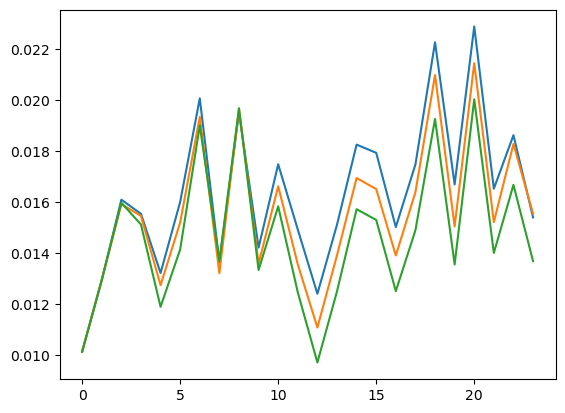

In [7]:
import matplotlib.pyplot as plt
for i in ipsl_ensemble:
    plt.plot(np.nanmean(i[:24,0,4],axis=(-1,-2)))

In [19]:
ipsl_ensemble.shape

(3, 119, 1, 9, 143, 144)

In [34]:
month_index = 0
batch_denormed = []
denormed_ensembles = []
denormed_batch_ensembles = []
for i in range(3):
    denormalized = []
    batch_denormed = []
    for index in range(len(ensembles[i]['state_surface'])-1):
        denorm_surface = lambda x,month_index: x*torch.from_numpy(train.surface_stds[month_index]) + torch.from_numpy(train.surface_means[month_index])
        denormalized.append(denorm_surface(ensembles[i]['state_surface'][index],month_index))
        batch_denormed.append(denorm_surface(torch.Tensor(ipsl_ensemble[i][index]),month_index))
        if(month_index == 11):
            month_index = 0
        else:
            month_index += 1
    denormed_ensembles.append(denormalized)
    denormed_batch_ensembles.append(batch_denormed)


# for i in ensemble0['state_surface']:
#     print(i.shape)

In [47]:
ensembles[0]['state_surface'].shape

AttributeError: 'list' object has no attribute 'shape'

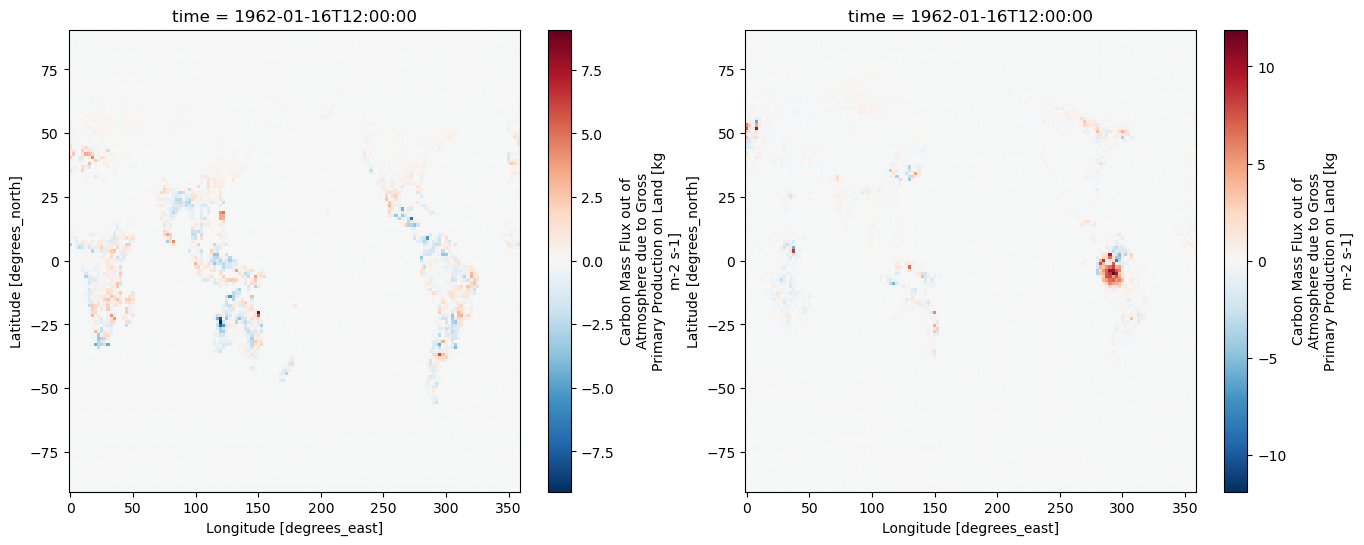

In [48]:
import xarray as xr
import matplotlib.pyplot as plt
#get shell
ds = xr.open_dataset(train.files[0])
shell = ds.isel(time=0)
var_name = 'gpp'
var_index = cfg.experiment.surface_variables.index(var_name)

#plot lat lon map of first rollout
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))
#shell[var_name].data = steps[49][0,0,0]
shell[var_name].data = ensembles[0]['state_surface'][0][0][3]
shell[var_name].plot.pcolormesh(ax=ax1)
shell[var_name].data = ensembles[-1]['state_surface'][-1][0][3]
shell[var_name].plot.pcolormesh(ax=ax2)

MovieWriter ffmpeg unavailable; using Pillow instead.


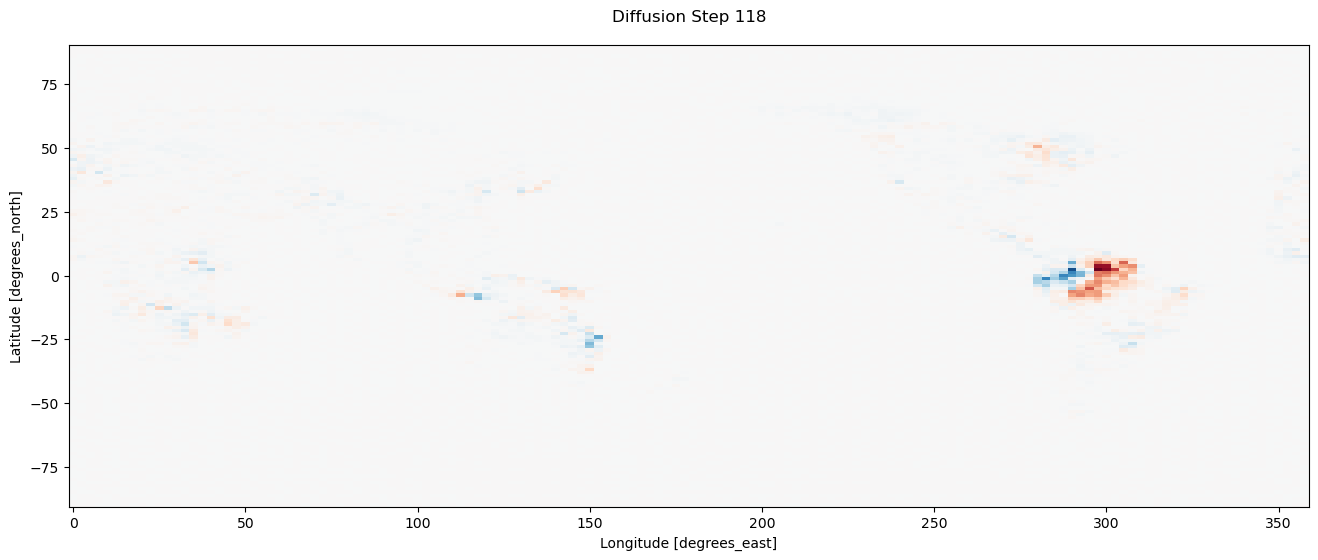

: 

In [49]:
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np


fig, ax1 = plt.subplots(1, figsize=(16, 6))
container = []
for time_step in range(119):
    shell['tas'].data = ensembles[0]['state_surface'][time_step][0][3]
   # line = ax1.pcolormesh(steps[time_step][0,0,0])
    line = shell['tas'].plot.pcolormesh(ax=ax1,add_colorbar=False)
    title = ax1.text(0.5,1.05,"Diffusion Step {}".format(time_step), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax1.transAxes, )
    container.append([line, title])
plt.title('')

ani = animation.ArtistAnimation(fig, container, interval=100, blit=True)
ani.save("diffusion_gpp_deltas.gif")

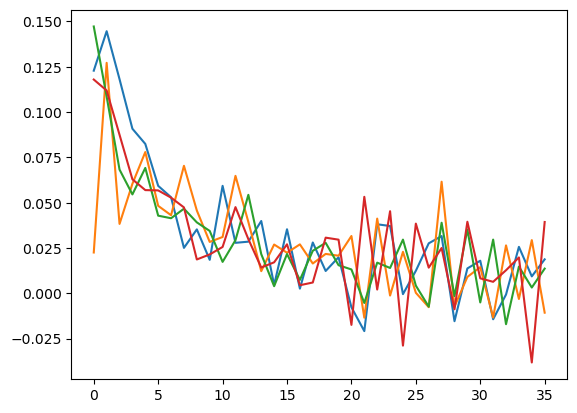

In [43]:
import numpy as np
for i in ensembles:
    plt.plot(np.mean(np.stack(i['state_surface'])[:36,0,0],axis=(-1,-2)))

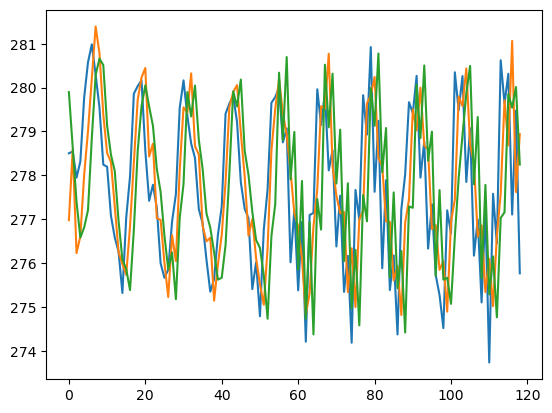

In [42]:
import matplotlib.pyplot as plt
for i in np.stack(denormed_ensembles):
    plt.plot(np.nanmean(np.stack(i)[:,0,0],axis=(-1,-2)))

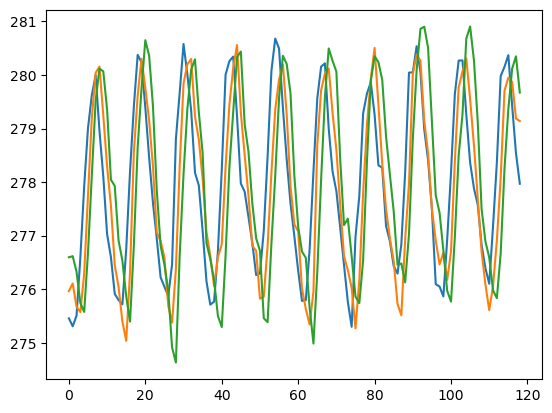

In [32]:
import matplotlib.pyplot as plt
for i in np.stack(denormed_batch_ensembles):
    plt.plot(np.nanmean(np.stack(i)[:,0,0],axis=(-1,-2)))

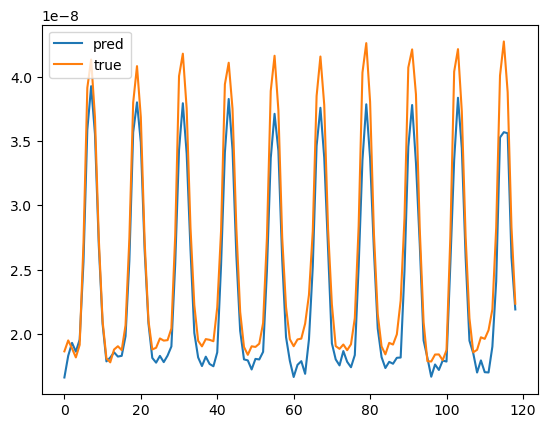

In [29]:
pred = np.stack(denormalized)
plt.plot(np.nanmean(pred[:,0,3],axis=(-1,-2)),label='pred')
plt.plot(np.nanmean(np.stack(batch_denormed)[:,0,3],axis=(-1,-2)),label='true')
plt.legend()